<a href="https://colab.research.google.com/github/pkrodev/ML_Tutorial/blob/main/9/Wieloklasowa_klasyfikacja_obraz%C3%B3w.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import shutil
folder_do_usuniecia = './images'
if os.path.exists(folder_do_usuniecia):
    shutil.rmtree(folder_do_usuniecia)
    print("Folder został usunięty.")
else:
    print("Folder nie istnieje.")

Folder nie istnieje.


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.applications import VGG19

np.set_printoptions(precision=6, suppress=True)

In [4]:
!wget https://storage.googleapis.com/esmartdata-courses-files/ann-course/flying-vehicles.zip
!unzip -q flying-vehicles.zip

--2024-03-27 23:35:26--  https://storage.googleapis.com/esmartdata-courses-files/ann-course/flying-vehicles.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.234.207, 142.251.180.207, 142.251.172.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.234.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1540232238 (1.4G) [application/x-zip-compressed]
Saving to: ‘flying-vehicles.zip’

flying-vehicles.zip 100%[===================>]   1.43G  32.5MB/s    in 47s     

2024-03-27 23:36:14 (31.4 MB/s) - ‘flying-vehicles.zip’ saved [1540232238/1540232238]



In [5]:
# Importowanie niezbędnych bibliotek
import os
import shutil

# Funkcja do kopiowania plików z jednego katalogu do drugiego
def copy_files(source_dir, dest_dir, filenames):
    """
    Funkcja kopiująca pliki z jednego katalogu źródłowego do docelowego.

    Parametry:
    source_dir (str): Ścieżka do katalogu źródłowego.
    dest_dir (str): Ścieżka do katalogu docelowego.
    filenames (list): Lista nazw plików do skopiowania.
    """
    for fname in filenames:
        src = os.path.join(source_dir, fname)
        dst = os.path.join(dest_dir, fname)
        shutil.copyfile(src, dst)

# Funkcja do tworzenia katalogów, jeśli nie istnieją
def make_dirs(dirs):
    """
    Funkcja tworząca katalogi, jeśli nie istnieją.

    Parametry:
    dirs (list): Lista ścieżek do katalogów do utworzenia.
    """
    for directory in dirs:
        if not os.path.exists(directory):
            os.mkdir(directory)

In [6]:
# Etap 1: Tworzenie katalogów dla danych treningowych, walidacyjnych i testowych

# Ścieżki do katalogów
base_dir = './data/planes'
make_dirs(['./images'])
data_dir = './images'
train_dir = os.path.join(data_dir, 'train')
valid_dir = os.path.join(data_dir, 'valid')
test_dir = os.path.join(data_dir, 'test')

# Lista katalogów
dirs = [train_dir, valid_dir, test_dir]

# Tworzenie katalogów, jeśli nie istnieją
make_dirs(dirs)


In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import TensorBoard

In [8]:
import os

classes = ['drone', 'passenger-plane', 'helicopter']

# Obliczanie minimalnego rozmiaru zbioru danych
total_size = float('inf')

# Iteracja po klasach obiektów
for cls in classes:
    # Ścieżka do katalogu z obiektami danej klasy
    class_dir = os.path.join(base_dir, cls)       #'./data/planes/drone'  ./data/planes/passenger-plane

    # Lista nazw plików obiektów danej klasy
    class_files = os.listdir(class_dir)

    # Filtrowanie plików obrazów
    class_files = [fname for fname in class_files if fname.split('.')[1].lower() in ['jpg', 'png', 'jpeg']]

    # Obliczanie minimalnego rozmiaru zbioru danych
    total_size = min(total_size, len(class_files))

# Obliczanie rozmiarów zbiorów treningowych, walidacyjnych i testowych
train_size = int(total_size * 0.7)
valid_size = int(total_size * 0.2)
test_size = total_size - train_size - valid_size

# Iteracja po klasach obiektów
for cls in classes:
    # Ścieżka do katalogu z obiektami danej klasy
    class_dir = os.path.join(base_dir, cls)

    # Lista nazw plików obiektów danej klasy
    class_files = os.listdir(class_dir)

    # Filtrowanie plików obrazów
    class_files = [fname for fname in class_files if fname.split('.')[1].lower() in ['jpg', 'png', 'jpeg']]

    # Przycinanie listy plików do ustalonego rozmiaru
    class_files = class_files[:total_size]

    # Podział plików na zbiory treningowy, walidacyjny i testowy
    train_files = class_files[:train_size]
    valid_files = class_files[train_size:train_size + valid_size]
    test_files = class_files[train_size + valid_size:]

    # Ścieżki do katalogów dla zbiorów treningowego, walidacyjnego i testowego
    train_dest = os.path.join(train_dir, cls)
    valid_dest = os.path.join(valid_dir, cls)
    test_dest = os.path.join(test_dir, cls)

    # Tworzenie katalogów dla zbiorów treningowego, walidacyjnego i testowego
    make_dirs([train_dest, valid_dest, test_dest])

    # Kopiowanie plików do odpowiednich katalogów
    copy_files(class_dir, train_dest, train_files)
    copy_files(class_dir, valid_dest, valid_files)
    copy_files(class_dir, test_dest, test_files)

    # Wyświetlanie informacji o liczbie plików w poszczególnych zbiorach danych
    print(f'{cls} - zbiór treningowy', len(train_files))
    print(f'{cls} - zbiór walidacyjny', len(valid_files))
    print(f'{cls} - zbiór testowy', len(test_files))

drone - zbiór treningowy 918
drone - zbiór walidacyjny 262
drone - zbiór testowy 132
passenger-plane - zbiór treningowy 918
passenger-plane - zbiór walidacyjny 262
passenger-plane - zbiór testowy 132
helicopter - zbiór treningowy 918
helicopter - zbiór walidacyjny 262
helicopter - zbiór testowy 132


In [9]:
import os

folder_path_drone = './images/train/drone'
files_list_drone = os.listdir(folder_path_drone)

In [10]:

import os

folder_path_plane = './images/train/passenger-plane'
files_list_plane = os.listdir(folder_path_plane)

In [11]:
import os

folder_path_heli = './images/train/helicopter'
files_list_heli = os.listdir(folder_path_heli)

(-0.5, 758.5, 421.5, -0.5)

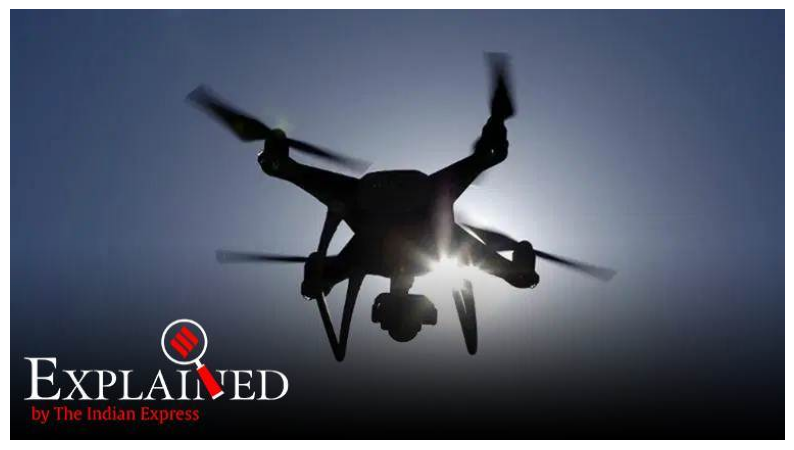

In [12]:
#@title Wybór po indeksach zdjęć dronów

idx = 559 #@param {type: 'slider', min:0, max: 918}
names_mapping=dict(enumerate(files_list_drone))
img_path = os.path.join(folder_path_drone, names_mapping[idx])
img = image.load_img(img_path)


plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

(-0.5, 1023.5, 681.5, -0.5)

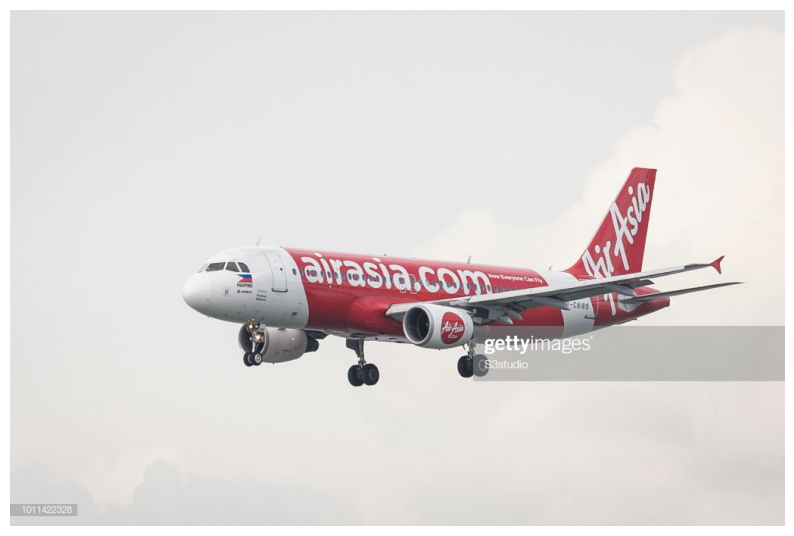

In [13]:

#@title Wybór po indeksach zdjęć samolotów

idx = 241 #@param {type: 'slider', min:0, max: 918}
names_mapping=dict(enumerate(files_list_plane))
img_path = os.path.join(folder_path_plane, names_mapping[idx])
img = image.load_img(img_path)


plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

(-0.5, 748.5, 505.5, -0.5)

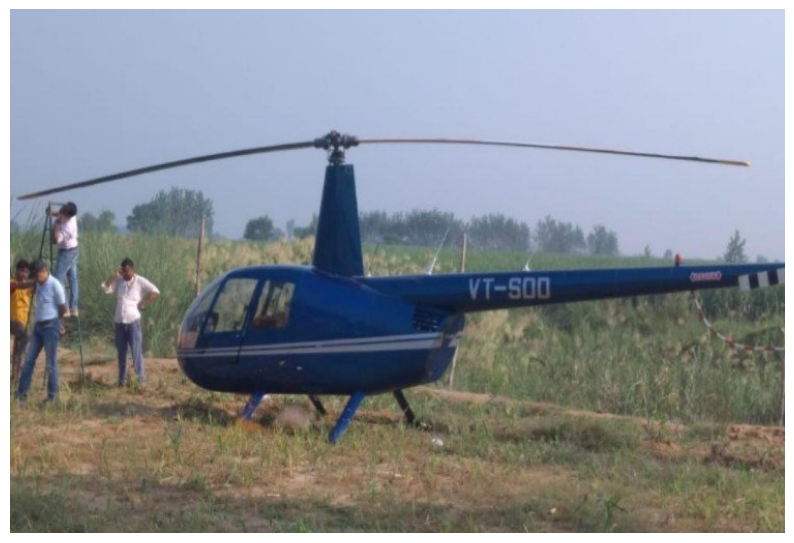

In [14]:

#@title Wybór po indeksach zdjęć helikopterów

idx = 176 #@param {type: 'slider', min:0, max: 918}
names_mapping=dict(enumerate(files_list_heli))
img_path = os.path.join(folder_path_heli, names_mapping[idx])
img = image.load_img(img_path)


plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

In [15]:
train_datagen = ImageDataGenerator(
    rotation_range=40,     # zakres kąta o który losowo zostanie wykonany obrót obrazów
    rescale=1./255.,
    width_shift_range=0.2,  # pionowe przekształcenia obrazu
    height_shift_range=0.2, # poziome przekształcenia obrazu
    shear_range=0.2,        # zares losowego przycianania obrazu
    zoom_range=0.2,         # zakres losowego przybliżania obrazu
    horizontal_flip=True,   # losowe odbicie połowy obrazu w płaszczyźnie poziomej
    fill_mode='nearest'     # strategia wypełniania nowo utworzonych pikseli, któe mogą powstać w wyniku przekształceń
)

# przeskalowujemy wszystkie obrazy o współczynnik 1/255
valid_datagen = ImageDataGenerator(rescale=1./255.)

train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                   target_size=(150, 150),
                                                   batch_size=32,
                                                   class_mode='categorical')

valid_generator = valid_datagen.flow_from_directory(directory=valid_dir,
                                                   target_size=(150, 150),
                                                   batch_size=32,
                                                   class_mode='categorical')

Found 2754 images belonging to 3 classes.
Found 786 images belonging to 3 classes.


In [16]:
def display_augmented_images(directory, idx):
    """
    Funkcja zwraca wykres przykładowych obrazów uzyskanych za pomocą techniki
    augmentacji danych.
    """
    fnames = [os.path.join(directory, fname) for fname in os.listdir(directory)]
    img_path = fnames[idx]
    img = image.load_img(img_path, target_size=(150, 150))

    x = image.img_to_array(img)
    x = x.reshape((1, ) + x.shape)

    i = 1
    plt.figure(figsize=(16, 8))
    for batch in train_datagen.flow(x, batch_size=1):
        plt.subplot(3, 4, i)
        plt.grid(False)
        imgplot = plt.imshow(image.array_to_img(batch[0]))
        i += 1
        if i % 13 == 0:
            break


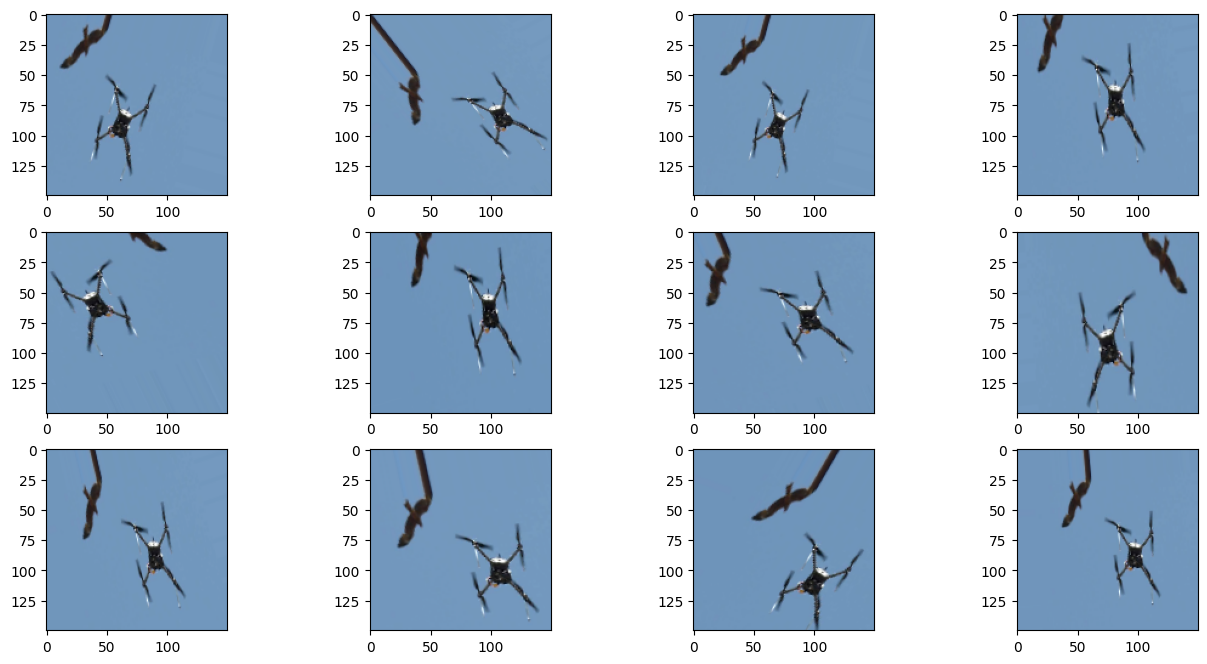

In [17]:
#@title Zbiór treningowy drone:
idx = 199 #@param {type:'slider', min:0, max:918}
display_augmented_images(folder_path_drone, idx)

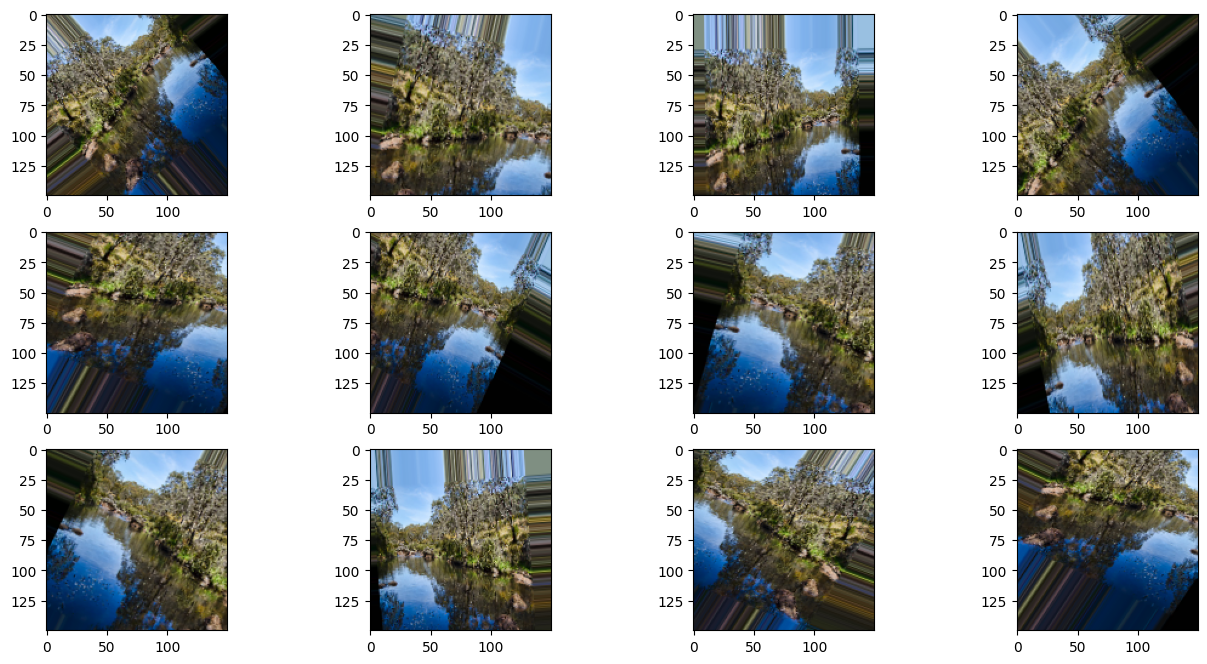

In [18]:
#@title Zbiór treningowy passenger:
idx = 859 #@param {type:'slider', min:0, max:918}
display_augmented_images(folder_path_plane, idx)

In [19]:
batch_size = 32
steps_per_epoch = train_size // batch_size
validation_steps = valid_size // batch_size

In [20]:
conv_base = VGG19(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
conv_base.trainable = True

def print_layers(model):
    for layer in model.layers:
        print(f'layer_name: {layer.name:13} trainable: {layer.trainable}')

print_layers(conv_base)

80134624/80134624 [==============================] - 1s 0us/step
layer_name: input_1       trainable: True
layer_name: block1_conv1  trainable: True
layer_name: block1_conv2  trainable: True
layer_name: block1_pool   trainable: True
layer_name: block2_conv1  trainable: True
layer_name: block2_conv2  trainable: True
layer_name: block2_pool   trainable: True
layer_name: block3_conv1  trainable: True
layer_name: block3_conv2  trainable: True
layer_name: block3_conv3  trainable: True
layer_name: block3_conv4  trainable: True
layer_name: block3_pool   trainable: True
layer_name: block4_conv1  trainable: True
layer_name: block4_conv2  trainable: True
layer_name: block4_conv3  trainable: True
layer_name: block4_conv4  trainable: True
layer_name: block4_pool   trainable: True
layer_name: block5_conv1  trainable: True
layer_name: block5_conv2  trainable: True
layer_name: block5_conv3  trainable: True
layer_name: block5_conv4  trainable: True
layer_name: block5_pool   trainable: True


In [21]:
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

print_layers(conv_base)

layer_name: input_1       trainable: False
layer_name: block1_conv1  trainable: False
layer_name: block1_conv2  trainable: False
layer_name: block1_pool   trainable: False
layer_name: block2_conv1  trainable: False
layer_name: block2_conv2  trainable: False
layer_name: block2_pool   trainable: False
layer_name: block3_conv1  trainable: False
layer_name: block3_conv2  trainable: False
layer_name: block3_conv3  trainable: False
layer_name: block3_conv4  trainable: False
layer_name: block3_pool   trainable: False
layer_name: block4_conv1  trainable: False
layer_name: block4_conv2  trainable: False
layer_name: block4_conv3  trainable: False
layer_name: block4_conv4  trainable: False
layer_name: block4_pool   trainable: False
layer_name: block5_conv1  trainable: True
layer_name: block5_conv2  trainable: True
layer_name: block5_conv3  trainable: True
layer_name: block5_conv4  trainable: True
layer_name: block5_pool   trainable: True


In [22]:
model = Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(units=256, activation='relu'))
model.add(layers.Dense(units=3, activation='softmax'))

model.compile(optimizer=optimizers.RMSprop(0.00001),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dense_1 (Dense)             (None, 3)                 771       
                                                                 
Total params: 22122563 (84.39 MB)
Trainable params: 11537411 (44.01 MB)
Non-trainable params: 10585152 (40.38 MB)
_________________________________________________________________


In [23]:
history = model.fit_generator(generator=train_generator,
                             steps_per_epoch=steps_per_epoch,
                             epochs=30,
                             validation_data=valid_generator,
                             validation_steps=validation_steps)

<ipython-input-23-78c443d13572>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_generator,


Epoch 1/30
28/28 [==============================] - 26s 647ms/step - loss: 1.0604 - accuracy: 0.4397 - val_loss: 0.9119 - val_accuracy: 0.5742
Epoch 2/30
28/28 [==============================] - 19s 681ms/step - loss: 0.9251 - accuracy: 0.5547 - val_loss: 0.7659 - val_accuracy: 0.6523
Epoch 3/30
28/28 [==============================] - 18s 636ms/step - loss: 0.8382 - accuracy: 0.6228 - val_loss: 0.6132 - val_accuracy: 0.7383
Epoch 4/30
28/28 [==============================] - 18s 633ms/step - loss: 0.7445 - accuracy: 0.6551 - val_loss: 0.6254 - val_accuracy: 0.7188
Epoch 5/30
28/28 [==============================] - 16s 572ms/step - loss: 0.7121 - accuracy: 0.6920 - val_loss: 0.5791 - val_accuracy: 0.7500
Epoch 6/30
28/28 [==============================] - 18s 663ms/step - loss: 0.6741 - accuracy: 0.7154 - val_loss: 0.5521 - val_accuracy: 0.7422
Epoch 7/30
28/28 [==============================] - 17s 599ms/step - loss: 0.6505 - accuracy: 0.7321 - val_loss: 0.5595 - val_accuracy: 0.7773

In [24]:
def plot_hist(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['accuracy'], name='accuracy', mode='markers+lines'))
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['val_accuracy'], name='val_accuracy', mode='markers+lines'))
    fig.update_layout(width=1000, height=500, title='Accuracy vs. Val Accuracy', xaxis_title='Epoki', yaxis_title='Accuracy', yaxis_type='log')
    fig.show()

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['loss'], name='loss', mode='markers+lines'))
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['val_loss'], name='val_loss', mode='markers+lines'))
    fig.update_layout(width=1000, height=500, title='Loss vs. Val Loss', xaxis_title='Epoki', yaxis_title='Loss', yaxis_type='log')
    fig.show()

plot_hist(history)

In [25]:

test_datagen = ImageDataGenerator(rescale=1./255.)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

y_prob = model.predict_generator(test_generator, test_generator.samples)
y_prob

Found 396 images belonging to 3 classes.


<ipython-input-25-d5c8c634ffeb>:10: UserWarning:

`Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.



array([[0.999635, 0.000276, 0.000089],
       [0.931644, 0.04329 , 0.025066],
       [0.936352, 0.060899, 0.00275 ],
       ...,
       [0.05046 , 0.000527, 0.949013],
       [0.000303, 0.000285, 0.999412],
       [0.01783 , 0.000485, 0.981685]], dtype=float32)

In [26]:
y_pred = np.argmax(y_prob, axis=1)
y_pred

array([0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 2, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 2,
       0, 2, 1, 0, 0, 0, 0, 0, 1, 2, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2,
       0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 1, 0,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 2, 1, 2, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 1, 2, 2, 2, 2, 0, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2,

In [27]:
predictions  = pd.DataFrame({'class': y_pred})
predictions

,class
0,0
1,0
2,0
3,0
4,0
...,...
391,0
392,2
393,2
394,2


In [28]:
y_true = test_generator.classes
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [29]:
y_pred = predictions['class'].values
y_pred

array([0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 2, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 2,
       0, 2, 1, 0, 0, 0, 0, 0, 1, 2, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2,
       0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 1, 0,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 2, 1, 2, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 1, 2, 2, 2, 2, 0, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2,

In [30]:
test_generator.class_indices

{'drone': 0, 'helicopter': 1, 'passenger-plane': 2}

In [31]:
classes = list(test_generator.class_indices.keys())
classes

['drone', 'helicopter', 'passenger-plane']

In [32]:
cm = confusion_matrix(y_true, y_pred)
cm

array([[103,   9,  20],
       [ 14, 109,   9],
       [ 24,   4, 104]])

In [33]:
def plot_confusion_matrix(cm):
    # Mulitclass classification, 3 classes
    cm = cm[::-1]
    cm = pd.DataFrame(cm, columns=classes, index=classes[::-1])

    fig = ff.create_annotated_heatmap(z=cm.values, x=list(cm.columns), y=list(cm.index), colorscale='ice', showscale=True, reversescale=True)
    fig.update_layout(width=500, height=500, title='Confusion Matrix', font_size=16)
    fig.show()

import plotly.figure_factory as ff
plot_confusion_matrix(cm)

In [34]:
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

                 precision    recall  f1-score   support

          drone       0.73      0.78      0.75       132
     helicopter       0.89      0.83      0.86       132
passenger-plane       0.78      0.79      0.78       132

       accuracy                           0.80       396
      macro avg       0.80      0.80      0.80       396
   weighted avg       0.80      0.80      0.80       396



In [35]:
errors = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred}, index=test_generator.filenames)
errors

,y_true,y_pred
drone/00000006.jpg,0,0
drone/00000015.jpeg,0,0
drone/00000017.jpg,0,0
drone/00000019.jpg,0,0
drone/00000036.jpg,0,0
...,...,...
passenger-plane/00001393.jpg,2,0
passenger-plane/00001401.jpg,2,2
passenger-plane/00001419.jpg,2,2
passenger-plane/00001464.jpg,2,2


In [36]:
errors['is_incorrect'] = (errors['y_true'] != errors['y_pred']) * 1
errors

,y_true,y_pred,is_incorrect
drone/00000006.jpg,0,0,0
drone/00000015.jpeg,0,0,0
drone/00000017.jpg,0,0,0
drone/00000019.jpg,0,0,0
drone/00000036.jpg,0,0,0
...,...,...,...
passenger-plane/00001393.jpg,2,0,1
passenger-plane/00001401.jpg,2,2,0
passenger-plane/00001419.jpg,2,2,0
passenger-plane/00001464.jpg,2,2,0


In [37]:
errors[errors['is_incorrect'] == 1].index

Index(['drone/00000051.png', 'drone/00000111.jpg', 'drone/00000268.jpg',
       'drone/00000280.jpg', 'drone/00000304.jpeg', 'drone/00000427.jpg',
       'drone/00000484.jpg', 'drone/00000490.jpg', 'drone/00000616.jpg',
       'drone/00000748.jpg', 'drone/00000782.jpg', 'drone/00000858.jpg',
       'drone/00000933.jpg', 'drone/00000997.jpg', 'drone/00001011.jpg',
       'drone/00001024.jpg', 'drone/00001036.jpg', 'drone/00001052.jpg',
       'drone/00001092.png', 'drone/00001098.jpg', 'drone/00001106.jpg',
       'drone/00001110.jpg', 'drone/00001112.jpg', 'drone/00001184.jpg',
       'drone/00001211.jpg', 'drone/00001355.jpg', 'drone/00001360.jpg',
       'drone/00001419.jpg', 'drone/00001420.jpg', 'helicopter/00000084.jpg',
       'helicopter/00000142.jpg', 'helicopter/00000315.jpg',
       'helicopter/00000380.jpg', 'helicopter/00000391.jpg',
       'helicopter/00000427.jpg', 'helicopter/00000428.jpg',
       'helicopter/00000434.jpg', 'helicopter/00000542.jpg',
       'helicopter/0

(-0.5, 499.5, 499.5, -0.5)

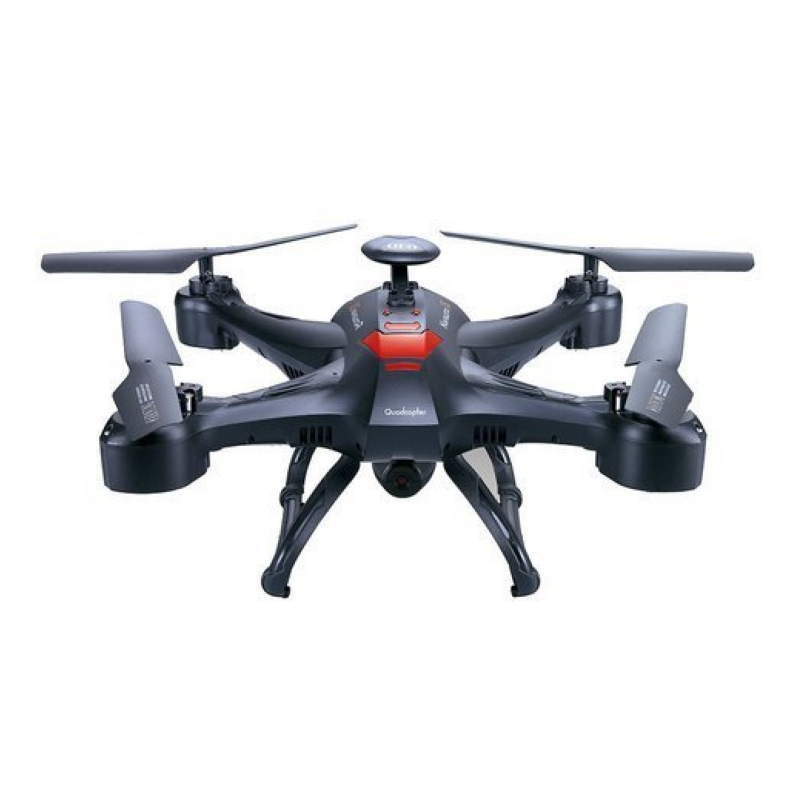

In [38]:
img = image.load_img('./images/test/helicopter/00001131.jpg')

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)